In [28]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
import matplotlib.pyplot as plt

SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs("artifacts", exist_ok=True)

In [29]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim=4, hidden_dim=128, action_dim=2):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, action_dim)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class ValueNet(nn.Module):
    def __init__(self, state_dim=4, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

def run_episode(env, policy):
    out = env.reset(seed=None)
    state = out[0] if isinstance(out, tuple) else out
    states, actions, rewards = [], [], []
    done = False
    while not done:
        st = torch.from_numpy(np.array(state, dtype=np.float32)).unsqueeze(0).to(device)
        logits = policy(st)
        action = torch.distributions.Categorical(logits=logits).sample().item()
        step = env.step(action)
        if len(step) == 5:
            nxt, r, term, trunc, _ = step
            done = term or trunc
        else:
            nxt, r, done, _ = step
        states.append(state)
        actions.append(action)
        rewards.append(r)
        state = nxt
    return states, actions, rewards


In [30]:
def train_pg(baseline, num_eps=200, batch_size=5,
             gamma=0.99, lr=1e-2,
             ent_start=0.01, ent_end=0.0):
    env = gym.make("CartPole-v1")
    env.reset(seed=SEED)
    policy = PolicyNet().to(device)
    opt_p = optim.Adam(policy.parameters(), lr=lr)

    if baseline == "value":
        crit = ValueNet().to(device)
        opt_v = optim.Adam(crit.parameters(), lr=lr)
    else:
        crit = opt_v = None

    best_state = None
    best_return0 = -1e9
    returns_curve = []

    buf_s, buf_a, buf_R = [], [], []
    buf_lens, buf_R0 = [], []
    total_updates = (num_eps + batch_size - 1)//batch_size
    upd = 0

    for ep in range(1, num_eps+1):
        states, actions, rewards = run_episode(env, policy)
        R0 = sum(rewards)
        returns_curve.append(R0)
        if R0 > best_return0:
            best_return0, best_state = R0, policy.state_dict().copy()

        G = 0; returns = []
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        buf_s.extend(states)
        buf_a.extend(actions)
        buf_R.extend(returns)
        buf_lens.append(len(states))
        buf_R0.append(returns[0])

        if ep % batch_size == 0 or ep == num_eps:
            upd += 1
            S = torch.tensor(buf_s, dtype=torch.float32, device=device)
            A = torch.tensor(buf_a, dtype=torch.long, device=device)
            R = torch.tensor(buf_R, dtype=torch.float32, device=device)

            if baseline == "none":
                adv = R
            elif baseline == "mean":
                meanb = float(np.mean(buf_R0))
                adv = R - meanb
            elif baseline == "rloo":
                tot = sum(buf_R0)
                parts, idx = [], 0
                for i,l in enumerate(buf_lens):
                    b = (tot - buf_R0[i])/(len(buf_lens)-1) if len(buf_lens)>1 else 0.0
                    parts.append(R[idx:idx+l] - b)
                    idx += l
                adv = torch.cat(parts)
            else:
                V = crit(S).squeeze()
                adv = R - V.detach()

            logits = policy(S)
            logp = torch.log_softmax(logits, dim=-1)
            sel = logp[range(len(A)), A]
            ent = torch.distributions.Categorical(logits=logits).entropy().mean()
            coef = ent_start + (ent_end - ent_start)*(upd-1)/(total_updates-1)
            loss_p = -(sel * adv).mean() - coef*ent

            opt_p.zero_grad()
            loss_p.backward()
            opt_p.step()

            if baseline == "value":
                val_loss = nn.functional.mse_loss(V, R)
                opt_v.zero_grad()
                val_loss.backward()
                opt_v.step()

            buf_s, buf_a, buf_R = [], [], []
            buf_lens, buf_R0 = [], []

    env.close()
    return returns_curve, best_state


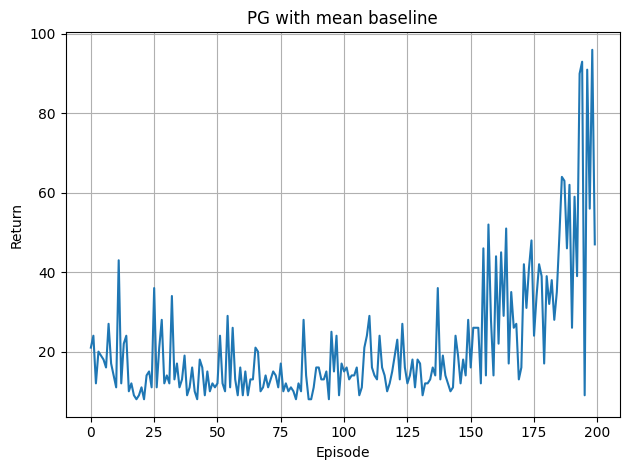

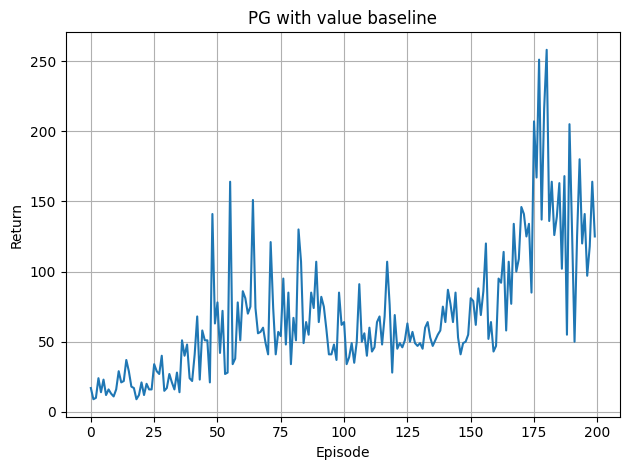

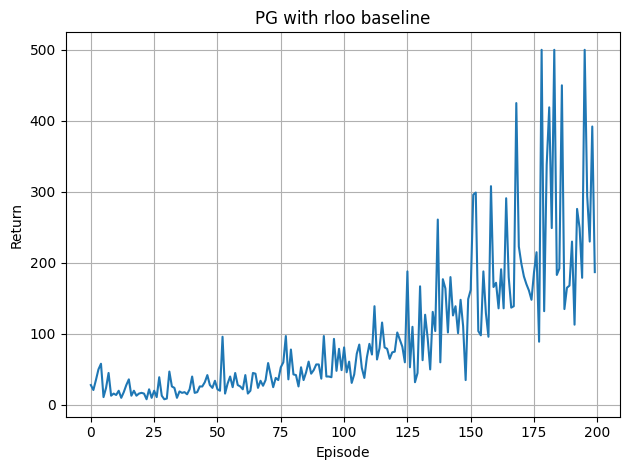

In [31]:
curves = {}
experts = {}
for b in ["mean", "value", "rloo"]:
    curve, state = train_pg(baseline=b, num_eps=200)
    curves[b] = curve
    experts[f"{b}_expert"] = state

torch.save(experts, "artifacts/experts.pth")

for b, curve in curves.items():
    plt.figure()
    plt.plot(curve)
    plt.title(f"PG with {b} baseline")
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

In [12]:
def evaluate_policy(policy, env, episodes=50, device="gpu"):
    policy.eval()
    total_reward = 0.0
    for ep in range(episodes):
        out = env.reset(seed=None)
        state = out[0] if isinstance(out, tuple) else out
        done = False
        ep_reward = 0.0
        while not done:
            st = torch.from_numpy(np.array(state, dtype=np.float32)).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = policy(st)
                action = torch.argmax(logits, dim=1).item()
            step_out = env.step(action)
            if len(step_out) == 5:
                next_state, reward, term, trunc, _ = step_out
                done = term or trunc
            else:
                next_state, reward, done, _ = step_out
            ep_reward += reward
            state = next_state
        total_reward += ep_reward
    return total_reward / episodes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1")

experts = torch.load("/kaggle/working/artifacts/experts.pth", map_location=device)

best_name = None
best_score = -float('inf')
best_policy = None

for name, sd in experts.items():
    policy = PolicyNet().to(device)
    policy.load_state_dict(sd)
    avg = evaluate_policy(policy, env, episodes=50, device=device)
    print(f"{name}: average reward = {avg:.2f}")
    if avg > best_score:
        best_score = avg
        best_name = name
        best_policy = policy

print(f"\nЛучшая политика: {best_name} с avg reward = {best_score:.2f}")

torch.save(best_policy.state_dict(), "best_expert.pth")


mean_expert: average reward = 277.40
value_expert: average reward = 238.20
rloo_expert: average reward = 500.00

Лучшая политика: rloo_expert с avg reward = 500.00


In [41]:
expert = PolicyNet().to(device)
checkpoint = torch.load("best_expert.pth", map_location=device)
expert.load_state_dict(checkpoint)
expert.eval()

env = gym.make("CartPole-v1")
max_steps = env.spec.max_episode_steps
demo_states, demo_actions = [], []
num_success = 0
num_desired = 2000

while len(demo_states) < num_desired:
    obs, _ = env.reset(seed=None)
    env.unwrapped.state = np.array([
        obs[0], obs[1],
        np.random.uniform(0),
        obs[3]
    ], dtype=np.float32)
    state = env.unwrapped.state.copy()

    states, actions = [], []
    done = False
    for t in range(max_steps):
        st_tensor = torch.from_numpy(state).unsqueeze(0).to(device)
        with torch.no_grad():
            logits = expert(st_tensor)
            a = torch.argmax(logits, dim=1).item()

        states.append(state.copy())
        actions.append(a)

        next_obs, reward, term, trunc, _ = env.step(a)
        done = term or trunc
        state = next_obs.copy()

        if done:
            break

    if len(states) == max_steps:
        demo_states.extend(states)
        demo_actions.extend(actions)
        num_success += 1



clone = PolicyNet().to(device)
opt_clone = optim.Adam(clone.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

X = torch.tensor(demo_states, dtype=torch.float32, device=device)
Y = torch.tensor(demo_actions, dtype=torch.long, device=device)
dataset = torch.utils.data.TensorDataset(X, Y)
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

for epoch in range(10):
    total_loss = 0.0
    for xb, yb in loader:
        logits = clone(xb)
        loss = loss_fn(logits, yb)
        opt_clone.zero_grad()
        loss.backward()
        opt_clone.step()
        total_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1}, loss = {total_loss/len(dataset):.4f}")


def eval_policy(policy, env, n=20, random_init=False, init_angle_range=0.05, device="cuda"):
    policy.eval()
    rewards = []
    for _ in range(n):
        out = env.reset(seed=None)
        state = out[0] if isinstance(out, tuple) else out
        if random_init:
            state = state.copy()
            state[2] = np.random.uniform(-init_angle_range, init_angle_range)
        done = False
        total_r = 0.0

        while not done:
            st = torch.from_numpy(np.array(state, dtype=np.float32)).unsqueeze(0).to(device)
            with torch.no_grad():
                logits = policy(st)
                action = torch.argmax(logits, dim=1).item()

            # Шаг среды
            step_out = env.step(action)
            if len(step_out) == 5:
                next_state, reward, term, trunc, _ = step_out
                done = term or trunc
            else:
                next_state, reward, done, _ = step_out

            total_r += reward
            state = next_state

        rewards.append(total_r)
    mean_r = float(np.mean(rewards))
    std_r = float(np.std(rewards))
    return mean_r, std_r

print("\n=== Оценка на обычных эпизодах ===")
env = gym.make("CartPole-v1")

exp_mean, exp_std = eval_policy(expert, env, n=20, random_init=False, device=device)
cl_mean, cl_std = eval_policy(clone, env, n=20, random_init=False, device=device)


print(f"Эксперт: mean={exp_mean:.1f} ±{exp_std:.1f}")
print(f"Клон: mean={cl_mean:.1f} ±{cl_std:.1f}")


Epoch 1, loss = 0.6446
Epoch 2, loss = 0.5756
Epoch 3, loss = 0.5099
Epoch 4, loss = 0.4488
Epoch 5, loss = 0.3942
Epoch 6, loss = 0.3458
Epoch 7, loss = 0.3033
Epoch 8, loss = 0.2681
Epoch 9, loss = 0.2409
Epoch 10, loss = 0.2177

=== Оценка на обычных эпизодах ===
Эксперт: mean=500.0 ±0.0
Клон: mean=336.2 ±90.5


In [42]:
print("\n=== Оценка при большем начальном угле ===")
exp2_mean, exp2_std = eval_policy(expert,  env, n=50, random_init=True, init_angle_range=100)
cl2_mean, cl2_std = eval_policy(clone, env, n=50, random_init=True, init_angle_range=100)
print(f"Эксперт: mean={exp2_mean:.1f} ±{exp2_std:.1f}")
print(f"Клон: mean={cl2_mean:.1f} ±{cl2_std:.1f}")


=== Оценка при большем начальном угле ===
Эксперт: mean=500.0 ±0.0
Клон: mean=321.0 ±139.2
